# Персонализированные предложения для интернет-магазина «В один клик»

# Описание проекта

Интернет-магазин «В один клик» сталкивается с падением активности покупателей. Привлечение новых клиентов стало менее эффективным, поэтому фокус на удержании постоянных клиентов через персонализированные предложения может стать решением. 

Задача — персонализировать предложения для увеличения покупательской активности, опираясь на анализ данных и бизнес-моделирование. 

# Описание данных

Данные для работы находятся в нескольких таблицах.

`market_file.csv`

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`
 Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например,

`'текущий_месяц'` или `'предыдущий_месяц'`.

- `Выручка` — сумма выручки за период.

`market_time.csv`

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv`

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

# Инструкция по выполнению проекта

Решать задачу вам нужно в два этапа:

1. Разработайте модель, которая предскажет вероятность снижения покупательской активности.
2. Выделите сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента. Ниже несколько примеров сегментов, но вы также можете выделить свой:
    - Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
    - Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
    - Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
    - Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [1]:
import sys
!pip install phik -q
!pip install shap -q

На всякий случай - проект выполняю локально

In [2]:
!pip install --upgrade scikit-learn==1.2.2 -q
!pip install --upgrade numpy==1.26.4 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade shap==0.45.0 -q
!pip install --upgrade phik==0.12.4 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade scipy==1.12.0 -q
!pip install --upgrade matplotlib==3.8.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [3]:
#import warnings
#warnings.filterwarnings('ignore')
from itertools import combinations
from math import log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import phik
import shap
shap.initjs()

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

In [4]:
sns.set_theme()
sns.set_palette('Set2')
RANDOM_STATE = 5

## **Загрузка данных**

1. Загрузка и подготовка данных:
   - Загрузить данные из файлов market_file.csv, market_money.csv, market_time.csv, money.csv, которые доступны по следующим путям:
     - /datasets/market_file.csv
     - /datasets/market_money.csv
     - /datasets/market_time.csv
     - /datasets/money.csv
   - Учесть, что в некоторых файлах в качестве разделителя значений используется точка с запятой, а для дробных чисел — запятая.
   - Проверить соответствие данных в таблицах заявленному в описании. Объединение и исследование данных будут произведены на следующих этапах.

In [5]:
def get_info(data: pd.DataFrame) -> None:
    '''
    Function for printing base information of dataframe
    :param data: dataframe for search
    '''
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())
    print('\nInfo about duplicates:\n', data.duplicated().sum())
    print('\nInfo about unique data in dataframe:')


In [6]:
market = pd.read_csv('/datasets/market_file.csv')
money = pd.read_csv('/datasets/market_money.csv')
time = pd.read_csv('/datasets/market_time.csv')
income_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

<u>**Выведем основную информацию из датафрема о поведении покупателя на сайте**</u>

In [7]:
market.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Для удобства дальнейшей работы изменим названия столбцов с кириллицы на латиницу

<u>Таблица переименования:</u>


| Кириллица                             | Латиница                          | Описание                                                                                                                                                                                                                         |
| ------------------------------------- | --------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `id`                                  | `id`                              | номер покупателя в корпоративной базе данных                                                                                                                                                                                     |
| `Покупательская активность`           | `customer_activity`               | рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».                                                                                                                               |
| `Тип сервиса`                         | `service_type`                    | уровень сервиса, например «премиум» и «стандарт»                                                                                                                                                                                 |
| `Разрешить сообщать`                  | `allow_reporting`                 | информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.                                                                                                            |
| `Маркет_актив_6_мес`                  | `market_activ_6_month`            | среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. |
| `Маркет_актив_тек_мес`                | `market_activ_cur`                | количество маркетинговых коммуникаций в текущем месяце.                                                                                                                                                                          |
| `Длительность`                        | `duration`                        | значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.                                                                                                                                     |
| `Акционные_покупки`                   | `promotional_purchases`           | среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев                                                                                                                                              |
| `Популярная_категория`                | `popular_category`                | самая популярная категория товаров у покупателя за последние 6 месяцев.                                                                                                                                                          |
| `Средний_просмотр_категорий_за_визит` | `average_category_view_per_visit` | показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.                                                                                                                              |
| `Неоплаченные_продукты_штук_квартал`  | `unpaid_items_for_quarter`        | исло неоплаченных товаров в корзине за последние 3 месяца.                                                                                                                                                                       |
| `Ошибка_сервиса`                      | `service_error`                   | число сбоев, которые коснулись покупателя во время посещения сайта.                                                                                                                                                              |
| `Страниц_за_визит`                    | `pages_per_visit`                 | Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца|


In [8]:
market.rename(columns={'Покупательская активность': 'customer_activity',
                       'Тип сервиса': 'service_type',
                       'Разрешить сообщать': 'allow_reporting',
                       'Маркет_актив_6_мес': 'market_activ_6_month',
                       'Маркет_актив_тек_мес': 'market_activ_cur',
                       'Длительность':'duration',
                       'Акционные_покупки': 'promotional_purchases',
                       'Популярная_категория': 'popular_category',
                       'Средний_просмотр_категорий_за_визит': 'average_category_view_per_visit',
                       'Неоплаченные_продукты_штук_квартал': 'unpaid_items_for_quarter',
                       'Ошибка_сервиса': 'service_error',
                       'Страниц_за_визит': 'pages_per_visit'
                      }, 
              inplace=True)

Проверим, что наименование произошло успешно

In [9]:
market.head()

id customer_activity service_type allow_reporting  \
0  215348         Снизилась      премиум              да   
1  215349         Снизилась      премиум              да   
2  215350         Снизилась    стандартт             нет   
3  215351         Снизилась    стандартт              да   
4  215352         Снизилась    стандартт             нет   

   market_activ_6_month  market_activ_cur  duration  promotional_purchases  \
0                   3.4                 5       121                   0.00   
1                   4.4                 4       819                   0.75   
2                   4.9                 3       539                   0.14   
3                   3.2                 5       896                   0.99   
4                   5.1                 3      1064                   0.94   

    popular_category  average_category_view_per_visit  \
0   Товары для детей                                6   
1   Товары для детей                                4   
2  Домашний текстиль                                5   
3   Товары для детей                                5   
4   Товары для детей                                3   

   unpaid_items_for_quarter  service_error  pages_per_visit  
0                         2              1                5  
1                         4              2                5  
2                         2              1                5  
3                         0              6                4  
4                         2              3                2

In [10]:
get_info(market)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1300 non-null   int64  
 1   customer_activity                1300 non-null   object 
 2   service_type                     1300 non-null   object 
 3   allow_reporting                  1300 non-null   object 
 4   market_activ_6_month             1300 non-null   float64
 5   market_activ_cur                 1300 non-null   int64  
 6   duration                         1300 non-null   int64  
 7   promotional_purchases            1300 non-null   float64
 8   popular_category                 1300 non-null   object 
 9   average_category_view_per_visit  1300 non-null   int64  
 10  unpaid_items_for_quarter         1300 non-null   int64  
 11  service_error                    1300 non-null   int64  
 12  pag

<u>**Выведем основную информацию из датафрема о выручке, которую получает магазин с покупателя**</u>

In [11]:
money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

<u>Таблица переименования столбцов</u>


| Кириллица | Латиница | Описание                                                  |
| --------- | -------- | --------------------------------------------------------- |
| `id`      | `id`     | номер покупателя в корпоративной базе данных.             |
| `Период`  | `period` | название периода, во время которого зафиксирована выручка |
| `Выручка` | `income` | сумма выручки за период.                                  |


In [12]:
money.rename(columns={'Период': 'period',
                      'Выручка': 'income'
                     }, 
             inplace=True)

In [13]:
get_info(money)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3900 non-null   int64  
 1   period  3900 non-null   object 
 2   income  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

Info about missing data:
 id        0
period    0
income    0
dtype: int64

Info about duplicates:
 0

Info about unique data in dataframe:


<u>**Выведем основную информацию из датафрема о времени (в минутах), которое покупатель провёл на сайте в течение периода.**</u>

In [14]:
time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

<U>Таблица переименования столбцов</u>

| Кириллица | Латиница  | Описание                                                       |
| --------- | --------- | -------------------------------------------------------------- |
| `id`      | `id`      | номер покупателя в корпоративной базе данных.                  |
| `Период`  | `period`  | название периода, во время которого зафиксировано общее время. |
| `минут`   | `minutes` | значение времени, проведённого на сайте, в минутах             |


In [15]:
time.rename(columns={'Период': 'period',
                     'минут': 'minutes'
                     }, 
             inplace=True)

In [16]:
get_info(time)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

Info about missing data:
 id         0
period     0
minutes    0
dtype: int64

Info about duplicates:
 0

Info about unique data in dataframe:


<u>**Выведем основную информацию из датафрема о среднемесячной прибыли покупателя за последние 3 месяца**</u>

In [17]:
income_money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

<u>Таблица переименования</u>


| Кириллица | Латиница | Описание          |
| --------- | -------- | ----------------- |
| `Прибыль` | `profit` | значение прибыли. |


In [18]:
income_money.rename(columns={'Прибыль': 'profit'},
                   inplace=True)

In [19]:
get_info(income_money)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

Info about missing data:
 id        0
profit    0
dtype: int64

Info about duplicates:
 0

Info about unique data in dataframe:


**Вывод**:

- В датафрейме `market` представлена информация о поведении покупателя на сайте. Для удобства работы с датафреймом было произведено переименование столбцов на латиницу, ниже представлена таблица перевода:

| Кириллица                             | Латиница                          |
| ------------------------------------- | --------------------------------- |
| `id`                                  | `id`                              |
| `Покупательская активность`           | `customer_activity`               |
| `Тип сервиса`                         | `service_type`                    |
| `Разрешить сообщать`                  | `allow_reporting`                 |
| `Маркет_актив_6_мес`                  | `market_activ_6_month`            |
| `Маркет_актив_тек_мес`                | `market_activ_cur`                |
| `Длительность`                        | `duration`                        |
| `Акционные_покупки`                   | `promotional_purchases`           |
| `Популярная_категория`                | `popular_category`                |
| `Средний_просмотр_категорий_за_визит` | `average_category_view_per_visit` |
| `Неоплаченные_продукты_штук_квартал`  | `unpaid_items_for_quarter`        |
| `Ошибка_сервиса`                      | `service_error`                   |
| `Страниц_за_визит`                    | `pages_per_visit`                 |
- В дататафрейме `money` представлена информация о выручке, которую получает магазин с покупателя. Для удобства работы с датафреймом было произведено переименование столбцов на латиницу, ниже представлена таблица перевода:

| Кириллица | Латиница |
| --------- | -------- |
| `Период`  | `period` |
| `Выручка` | `income` |
- В дататафрейме `money` представлена информация о выручке, которую получает магазин с покупателя. Для удобства работы с датафреймом было произведено переименование столбцов на латиницу, ниже представлена таблица перевода:

| Кириллица | Латиница  |
| --------- | --------- |
| `Период`  | `period`  |
| `минут`   | `minutes` |
- В дататафрейме `money` представлена информация о выручке, которую получает магазин с покупателя. Для удобства работы с датафреймом было произведено переименование столбцов на латиницу, ниже представлена таблица перевода:

| Кириллица | Латиница |
| --------- | -------- |
| `Прибыль` | `profit` |
- Во всех датафреймах не обнаружено пропусков, и явных дубликатов.

## **Предобработка данных**

Проведем необходимую предобработку данных. Названия столбцов уже были заменены на латиницу

In [20]:
def get_unique_values_with_counts(data: pd.DataFrame, col: pd.Series) -> str:
    """
    get values and their names into one str line
    params: data: dataframe for research
            col: column from dataframe for research
    return: str line with names and values
    """
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    result = [f'{value} ({count})' for value, count in zip(unique_values, value_counts)]
    return ', '.join(result)


def unique_data(data: pd.DataFrame) -> None:
    """
    Output of unique data if it's count less tan ten
    params: data: dataframe for research
    """
    for col in data:
        if len(data[col].unique()) < 10:
            print(f'{col}: {get_unique_values_with_counts(data, col)}')

Посмотрим на уникальные значения в датафреймах для поиска неявных дубликатов

In [21]:
unique_data(market)

customer_activity: Снизилась (802), Прежний уровень (498)
service_type: премиум (914), стандартт (376), стандарт (10)
allow_reporting: да (962), нет (338)
market_activ_cur: 5 (669), 4 (323), 3 (308)
popular_category: Товары для детей (330), Домашний текстиль (251), Косметика и аксесуары (223), Техника для красоты и здоровья (184), Кухонная посуда (174), Мелкая бытовая техника и электроника (138)
average_category_view_per_visit: 6 (356), 4 (312), 5 (263), 3 (177), 2 (106), 1 (86)


In [22]:
unique_data(money)

period: препредыдущий_месяц (1300), текущий_месяц (1300), предыдущий_месяц (1300)


In [23]:
unique_data(time)

period: текущий_месяц (1300), предыдцщий_месяц (1300)


In [24]:
unique_data(income_money)

В датафрейме `market` мы видим неявный дубликат к наименованию `стандарт`. Заменим `стандартт` на `стандарт`.

В датафрейме `time` опечатка в `предыдущий месяц`, в датафрейме `market` опечатка в `Косметика и аксессуары` исправим их.

In [25]:
market.loc[market['popular_category'] == 'Косметика и аксесуары', 'popular_category'] = 'Косметика и аксессуары'

In [26]:
market['popular_category'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [27]:
time.loc[time['period'] == 'предыдцщий_месяц', 'period'] = 'предыдущий_месяц'

In [28]:
market.loc[market['service_type'] == 'стандартт', 'service_type'] = 'стандарт'

Проверим что удаление неявных дубликатов и исправление опечатки произошло успешно.

In [29]:
market['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [30]:
time['period'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Вывод**:
- Для датафрейма `market` был удален неявный дубликат в столбце `service_type`
- Для датафрейма `time` и `market` были исправлены опечатки в данных

## **Исследовательский анализ данных**

Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Проведем статистический анализ данных для каждого датафрейма. Для этого создадим словари с категориальными и количественными признаками, построим графики распределений, а также рассмотрим квартили, среднее, медиану и подобные параметры для данных.

In [31]:
def categorial_plot(df: pd.DataFrame, title: str, features: dict) -> None:
    '''
    Function for plotting categorial distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data = df[feature].value_counts().to_frame().reset_index()
        if len(data['count'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(20, 4))
            fig.suptitle(f'Распределение для {feat_ru}')
            axes[0].yaxis.grid(True)
            sns.barplot(data=data, y=feature, x='count', ax=axes[0])
            axes[0].set_xlabel('Количество', fontsize=12)
            axes[0].set_ylabel(feat_ru, fontsize=12)
            axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
        else:
            print(f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

In [32]:
def numerical_plot(df: pd.DataFrame, title: str, features: dict):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        if df[feature].dtype == int and len(df[feature].unique()) < 100:
            sns.countplot(data=df, x=feature, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, ax=axes[0], bins=round(log((len(df[feature].unique()) + 1)), ))
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Количество')
            axes[num].set_xlabel(feat_ru)

**Датафрейм market, который содержит данные о поведении покупателя на сайте**

In [33]:
market_categorial = {
    'customer_activity': 'Покупательская активность',
    'service_type': 'Тип сервиса',
    'allow_reporting': 'Разрешить сообщать',
    'popular_category': 'Популярная_категория',
    
}

In [34]:
market_numerical = {
    'market_activ_6_month': 'Маркет_актив_6_мес',
    'market_activ_cur': 'Маркет_актив_тек_мес',
    'duration': 'Длительность',
    'promotional_purchases': 'Акционные_покупки',
    'average_category_view_per_visit': 'Средний_просмотр_категорий_за_визит',
    'unpaid_items_for_quarter': 'Неоплаченные_продукты_штук_квартал',
    'service_error': 'Ошибка_сервиса',
    'pages_per_visit': 'Страниц_за_визит'
}

In [35]:
market[market_categorial.keys()].describe()

customer_activity service_type allow_reporting  popular_category
count               1300         1300            1300              1300
unique                 2            2               2                 6
top      Прежний уровень     стандарт              да  Товары для детей
freq                 802          924             962               330

Графики категориальных признаков для Распределение для категориальных признаков из датасета market


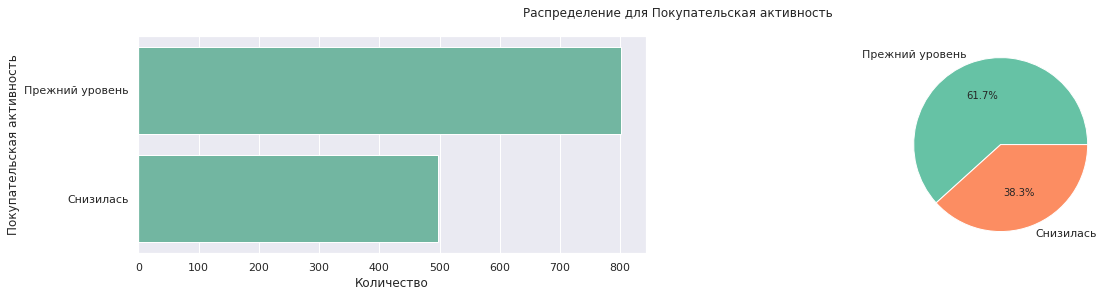

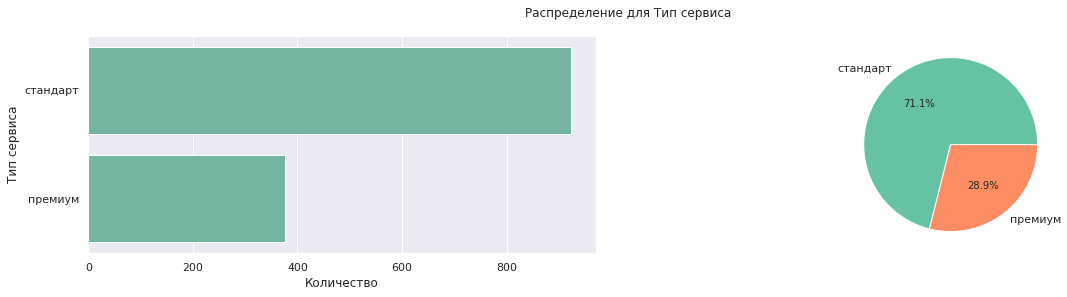

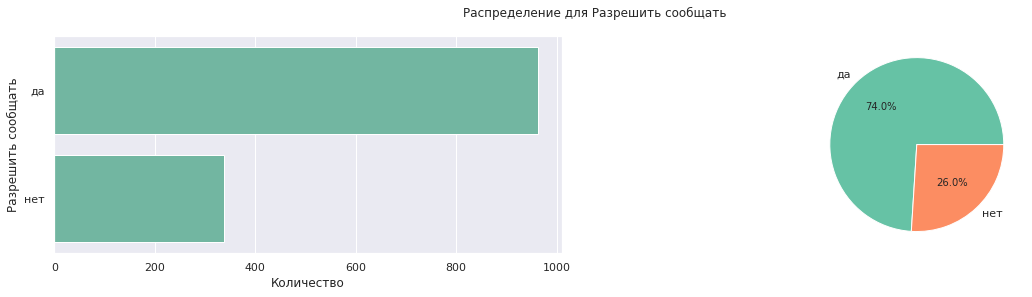

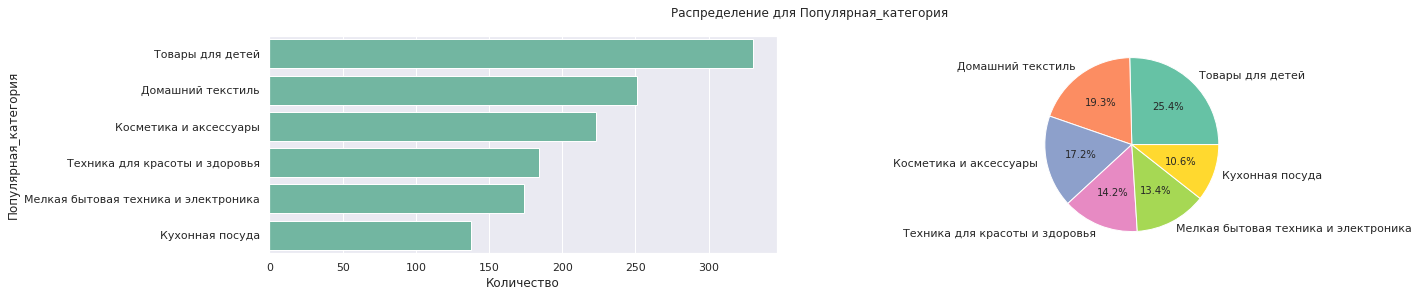

In [36]:
categorial_plot(market, 'Распределение для категориальных признаков из датасета market', market_categorial)

по графикам можно сделать вывод, что:
- Покупательская активность в большем количестве случаев осталась на прежнем уровне
- Пользователи в основном используют стандартный тип сервиса
- 74% пользователей разрешили сообщать им о акциях и прочем при помощи рассылки
- Самая популярная категория среди пользователей это товары для детей, далее идут домашний текстиль, косметика и аксесуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда в порядке убывания популярности категорий

In [37]:
market[market_numerical.keys()].describe()

market_activ_6_month  market_activ_cur     duration  \
count           1300.000000       1300.000000  1300.000000   
mean               4.253769          4.011538   601.898462   
std                1.014814          0.696868   249.856289   
min                0.900000          3.000000   110.000000   
25%                3.700000          4.000000   405.500000   
50%                4.200000          4.000000   606.000000   
75%                4.900000          4.000000   806.000000   
max                6.600000          5.000000  1079.000000   

       promotional_purchases  average_category_view_per_visit  \
count            1300.000000                       1300.00000   
mean                0.319808                          3.27000   
std                 0.249843                          1.35535   
min                 0.000000                          1.00000   
25%                 0.170000                          2.00000   
50%                 0.240000                          3.00000   
75%                 0.300000                          4.00000   
max                 0.990000                          6.00000   

       unpaid_items_for_quarter  service_error  pages_per_visit  
count               1300.000000    1300.000000      1300.000000  
mean                   2.840000       4.185385         8.176923  
std                    1.971451       1.955298         3.978126  
min                    0.000000       0.000000         1.000000  
25%                    1.000000       3.000000         5.000000  
50%                    3.000000       4.000000         8.000000  
75%                    4.000000       6.000000        11.000000  
max                   10.000000       9.000000        20.000000

Графики количественных признаков для Распределение для количественных признаков из датасета market


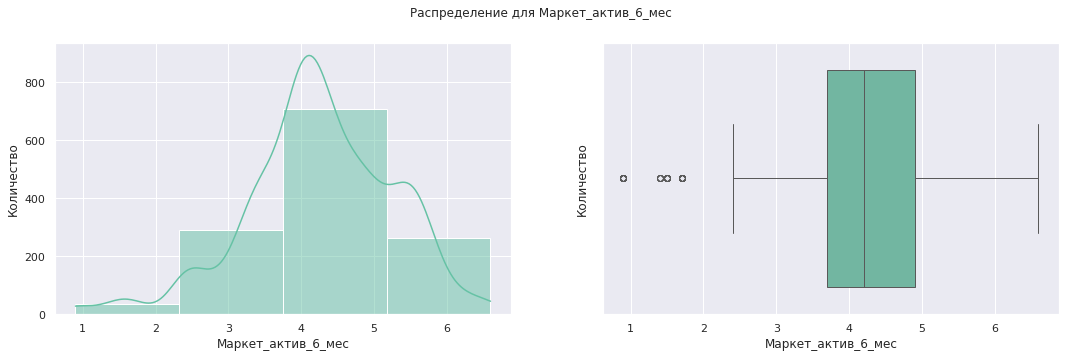

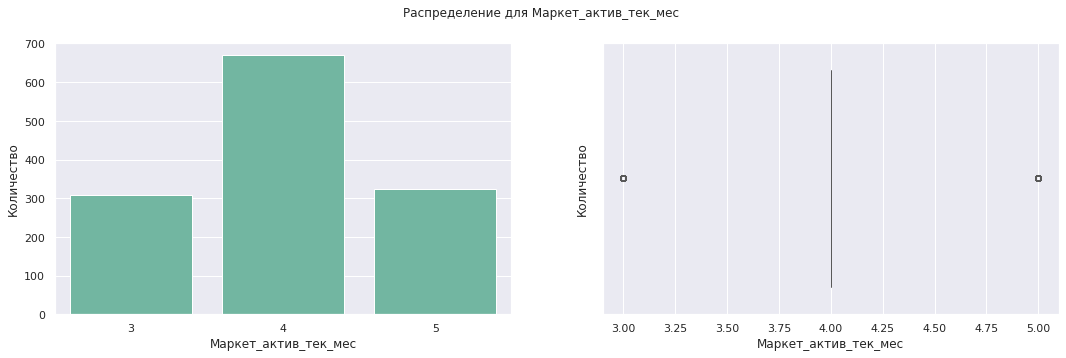

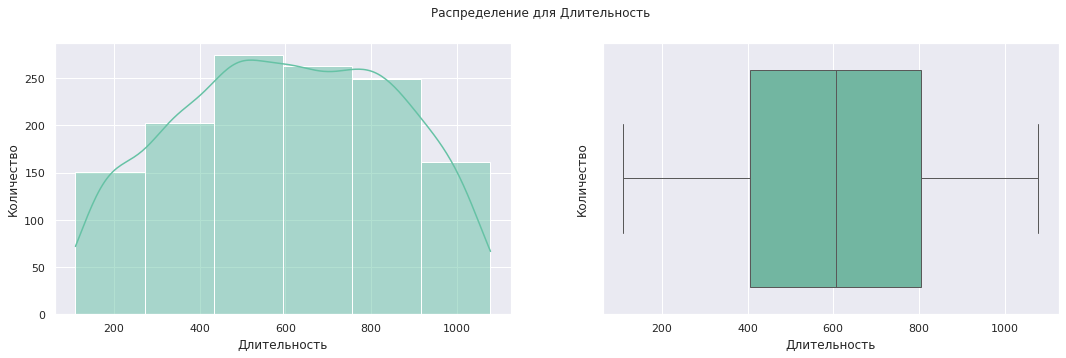

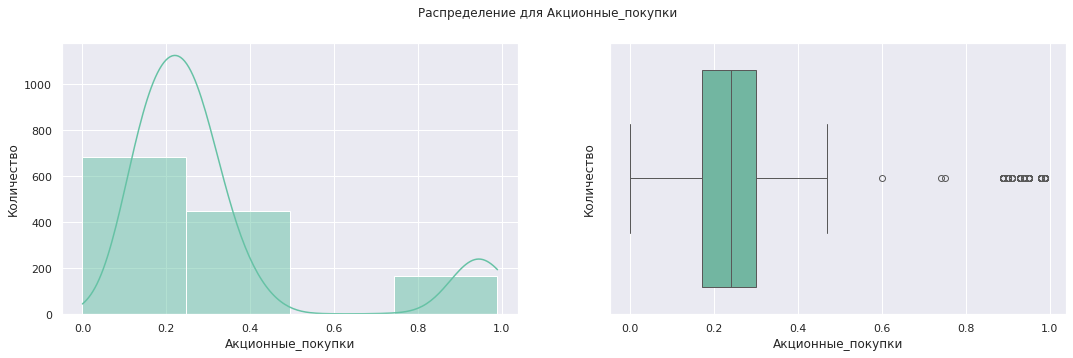

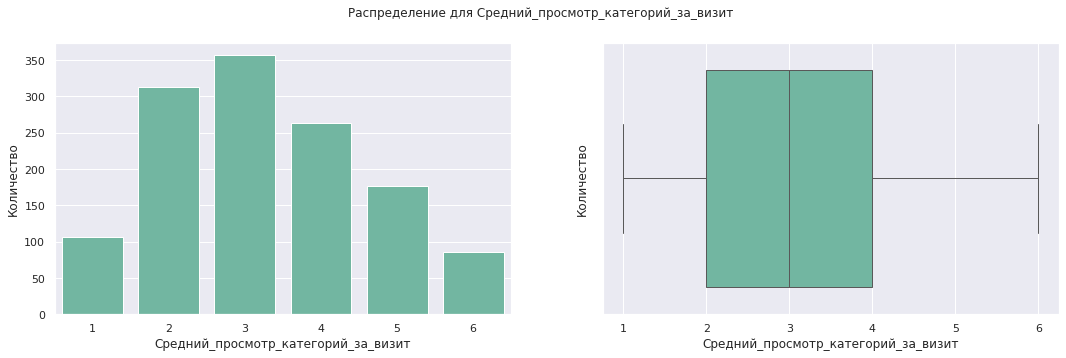

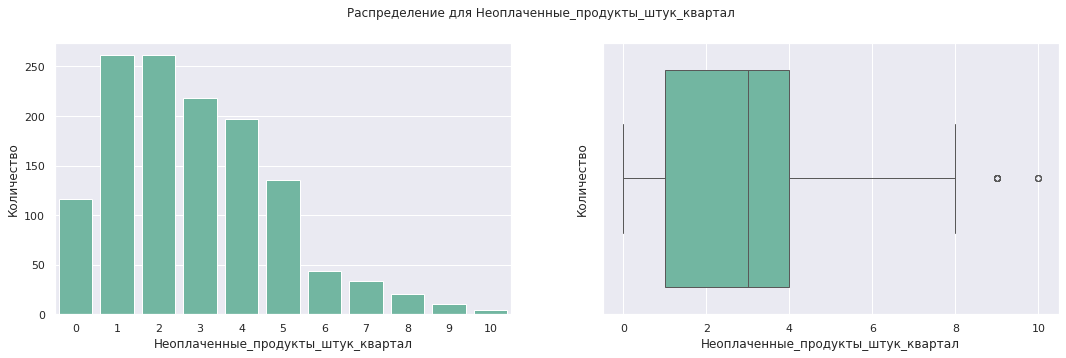

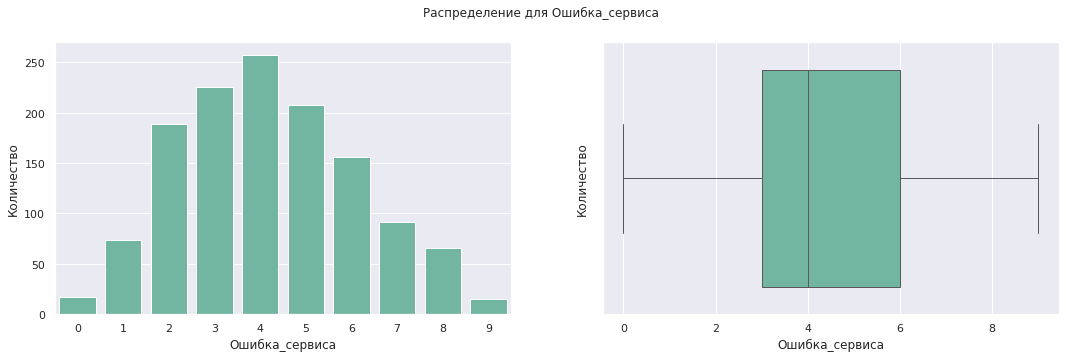

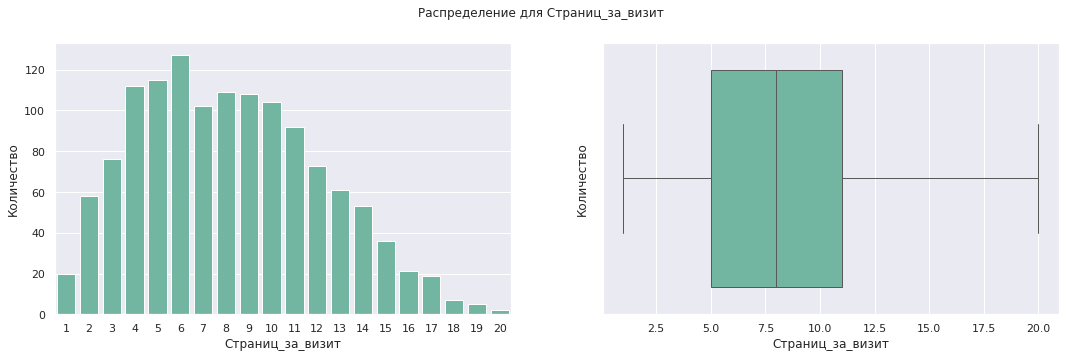

In [39]:
numerical_plot(market, 'Распределение для количественных признаков из датасета market', market_numerical)

- Для `market_activ_6_month` нельзя сказать о каком-то стандартном распределении - наблюдаются пики для значений 4 и 5,5
- Поскольку `market_activ_cur` имеет дискретные значения, о распределении ничего нельзя сказать, однако большая доля активности в месяц приходится на значение 4
- Для `duration` также нельзя сказать как о каком-то стандартном характере распределения, заметен лишь характерный пик значений в районе 550 и 600 дней
- Для `promotional_purchases` видно выброс в районе значения 0.9 - покупатель скорее всего заказывает только при наличии акций, это вполне возможные данные
- Для `average_category_view_per_visit` виден пик для значения 3, однако это дискретные значения и мы не можем сказать о каком-то распределении, однако напоминает нормальное распределение
- Для `unpaid_items_for_quarter` пики у значений 1 и 2, одинаковые по количеству, поскольку значения дискетны, о характере распределения сказать ничего нельзя, однако похоже на нормальное распределение со смещением влево
- Для `service_error` пик приходится на значение 4, однако это дискретные значения и мы не можем сказать о каком-то распределении, однако напоминает нормальное распределение
- Для `pages_per_visit` пик находится на значение 6, распределение дискретное, однако напоминает нормальное распреление со смещением влево

**Датафрейм money с данными о выручке, которую получает магазин с покупателя**

In [40]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3900 non-null   int64  
 1   period  3900 non-null   object 
 2   income  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [41]:
money_categorial = {'period': 'Период',}

In [42]:
money_numerical = {'income': 'Выручка'}

In [43]:
money[money_categorial.keys()].describe()

period
count                  3900
unique                    3
top     препредыдущий_месяц
freq                   1300

In [44]:
categorial_plot(money, 'Распределение для категориальных признаков из датасета money', money_categorial)

Графики категориальных признаков для Распределение для категориальных признаков из датасета money
Для категориального признака "Период" одинаковое количество данных на все группы: 1300


Как можно заметить, для категориального признака `period` данные делятся на три равные группы по 1300

In [45]:
money[money_numerical.keys()].describe()

income
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000

Графики количественных признаков для Распределение для количественных признаков из датасета market


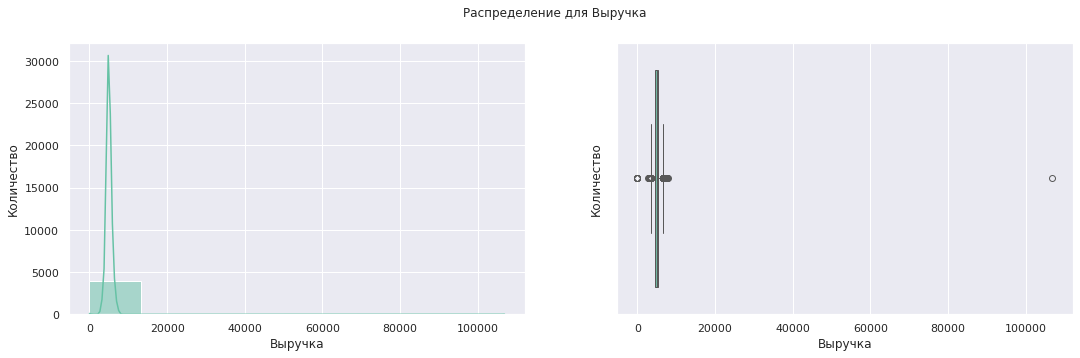

In [46]:
numerical_plot(money, 'Распределение для количественных признаков из датасета market', money_numerical)

можно заметить один выброс более 100000 выручки и нулевой выручки, уберем их из данных и построим графики еще раз как для категориальных, так и для количественных признаков

In [47]:
money = money.loc[~money['id'].isin(money.query('income > 100000')['id'].unique())]

In [48]:
money = money.loc[~money['id'].isin(money.query('income == 0')['id'].unique())]

In [49]:
money[money_numerical.keys()].describe()

income
count  3888.000000
mean   5007.255658
std     679.193461
min    2758.700000
25%    4591.950000
50%    4959.000000
75%    5363.000000
max    7799.400000

Графики количественных признаков для Распределение для количественных признаков из датасета market


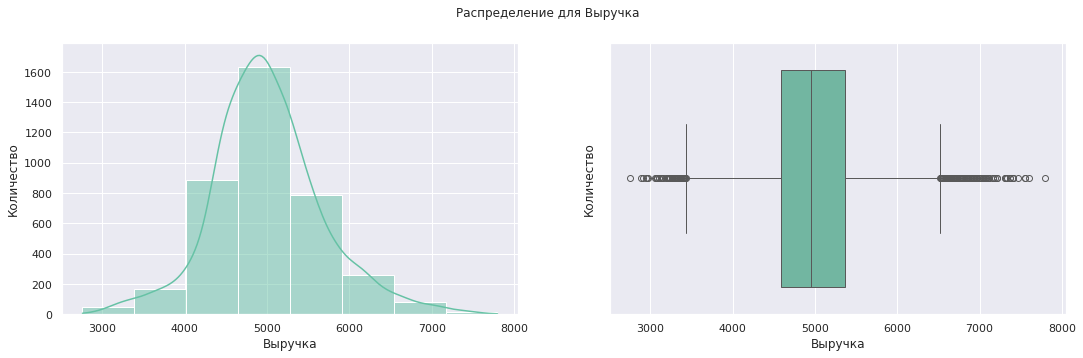

In [50]:
numerical_plot(money, 'Распределение для количественных признаков из датасета market', money_numerical)

На графике можно наблюдать нормальное распределение с небольшим смешением симметрии влево.

In [51]:
money[money_categorial.keys()].describe()

period
count                  3888
unique                    3
top     препредыдущий_месяц
freq                   1296

In [52]:
categorial_plot(money, 'Распределение для категориальных признаков из датасета money', money_categorial)

Графики категориальных признаков для Распределение для категориальных признаков из датасета money
Для категориального признака "Период" одинаковое количество данных на все группы: 1296


удаление строчек из датафрейма не сильно повлияло на распределение для категориальных признаков

**Датафрейм time, с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода**

In [53]:
time_numerical = {
    'minutes': 'минут'
}

In [54]:
time_categorial = {
    'period': 'Период',
}

In [55]:
time[time_numerical.keys()].describe()

minutes
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

Графики количественных признаков для Распределение для количественных признаков из датасета time


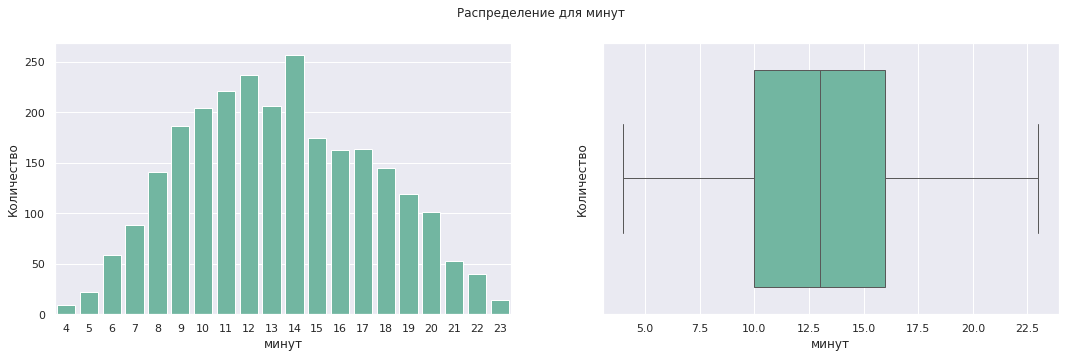

In [56]:
numerical_plot(time, 'Распределение для количественных признаков из датасета time', time_numerical)

In [57]:
time[time_categorial.keys()].describe()

period
count            2600
unique              2
top     текущий_месяц
freq             1300

In [58]:
categorial_plot(time, 'Распределение для категориальных признаков из датасета time', time_categorial)

Графики категориальных признаков для Распределение для категориальных признаков из датасета time
Для категориального признака "Период" одинаковое количество данных на все группы: 1300


**Датафрейм income_money с данными о среднемесячной прибыли покупателя за последние 3 месяца**

In [59]:
numerical_income_money = {
    'profit': 'Прибыль'
}

In [60]:
income_money[numerical_income_money.keys()].describe()

profit
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

Графики количественных признаков для Распределение для количественных признаков из датасета time


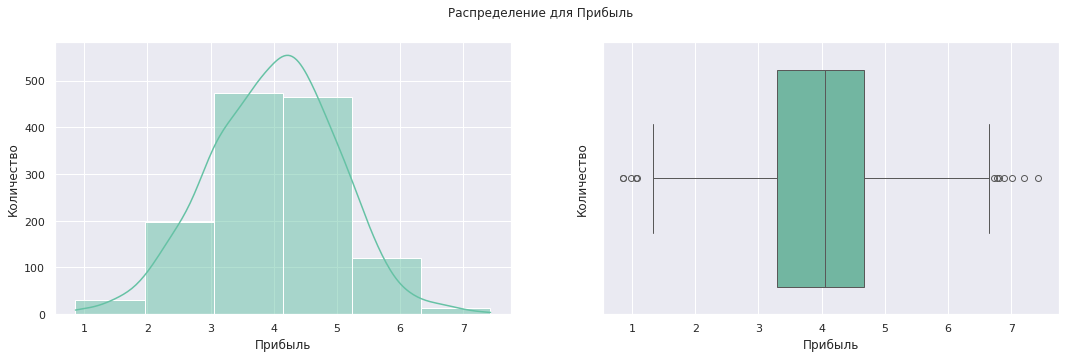

In [61]:
numerical_plot(income_money, 'Распределение для количественных признаков из датасета time', numerical_income_money)

**Вывод:**
- В датафрейме `market`:
    - для категориальных признаков:
        - Покупательская активность в большем количестве случаев осталась на прежнем уровне
        - Пользователи в основном используют стандартный тип сервиса
        - 74% пользователей разрешили сообщать им о акциях и прочем при помощи рассылки
        - Самая популярная категория среди пользователей это товары для детей, далее идут домашний текстиль, косметика и аксесуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда в порядке убывания популярности категорий
    - для количественных признаков:
        - Для `market_activ_6_month` нельзя сказать о каком-то стандартном распределении - наблюдаются пики для значений 4 и 5,5
        - Поскольку `market_activ_cur` имеет дискретные значения, о распределении ничего нельзя сказать, однако большая доля активности в месяц приходится на значение 4
        - Для `duration` также нельзя сказать как о каком-то стандартном характере распределения, заметен лишь характерный пик значений в районе 550 и 600 дней
        - Для `promotional_purchases` видно выброс в районе значения 0.9 - покупатель скорее всего заказывает только при наличии акций, это вполне возможные данные
        - Для `average_category_view_per_visit` виден пик для значения 3, однако это дискретные значения и мы не можем сказать о каком-то распределении, однако напоминает нормальное распределение
        - Для `unpaid_items_for_quarter` пики у значений 1 и 2, одинаковые по количеству, поскольку значения дискетны, о характере распределения сказать ничего нельзя, однако похоже на нормальное распределение со смещением влево
        - Для `service_error` пик приходится на значение 4, однако это дискретные значения и мы не можем сказать о каком-то распределении, однако напоминает нормальное распределение
        - Для `pages_per_visit` пик находится на значение 6, распределение дискретное, однако напоминает нормальное распреление со смещением влево
- В датафрейме `money`:
    - было удален выброc с выручкой более 100000
    - нормально распределен признак `income`, отвечаютщий за сумму выручки за период
    - количество данных за период разделяется на три категории данных, одинаковым по соотношению
    - **в конечном датафрейме были выделены только пользователи с активностью более нуля**
- В датафреме `time`:
    - нормально несимметрично со смещением влево распределен признак `time`
    - Для категориального признака `period` одинаковое количество данных на все группы: 1300
- В датафрейме `income_money`:
    - Нормально несимметрично со смещение вправо распределен признак `profit`

## **Объединение таблиц**


Для датафреймов `money`, `time` сделаем отдельные столбцы для каждого периода. Для сохранения удобства и стиля столбцы будут на латинице.

<u> Таблица перевода </u>

| Кириллица | Латиница |
| --- | --- |
|  предыдущий_месяц  |  income_last  |
|  препредыдущий_месяц  |  income_previos  |
|  текущий_месяц  |  income_curr  |

In [62]:
money_pivot = (money
               .pivot_table(index='id', columns='period', values='income', aggfunc='first')
               .rename(columns={
                   'предыдущий_месяц': 'income_last',
                   'препредыдущий_месяц': 'income_previos',
                   'текущий_месяц': 'income_curr'
               })
              .reset_index())

In [63]:
money_pivot.head()

period      id  income_last  income_previos  income_curr
0       215349       5216.0          4472.0       4971.6
1       215350       5457.5          4826.0       5058.4
2       215351       6158.0          4793.0       6610.4
3       215352       5807.5          4594.0       5872.5
4       215353       4738.5          5124.0       5388.5

In [64]:
time_pivot = (time
              .pivot_table(index='id', columns='period', values='minutes', aggfunc='first')
              .rename(columns={
                   'предыдущий_месяц': 'time_last',
                   'текущий_месяц': 'time_curr'
              })
              .reset_index())

In [65]:
time_pivot.head()

period      id  time_last  time_curr
0       215348         13         14
1       215349         12         10
2       215350          8         13
3       215351         11         13
4       215352          8         11

In [66]:
df = money_pivot.merge(market, on='id').merge(time_pivot, on='id')

In [67]:
df.head()

id  income_last  income_previos  income_curr customer_activity  \
0  215349       5216.0          4472.0       4971.6         Снизилась   
1  215350       5457.5          4826.0       5058.4         Снизилась   
2  215351       6158.0          4793.0       6610.4         Снизилась   
3  215352       5807.5          4594.0       5872.5         Снизилась   
4  215353       4738.5          5124.0       5388.5         Снизилась   

  service_type allow_reporting  market_activ_6_month  market_activ_cur  \
0      премиум              да                   4.4                 4   
1     стандарт             нет                   4.9                 3   
2     стандарт              да                   3.2                 5   
3     стандарт             нет                   5.1                 3   
4     стандарт              да                   3.3                 4   

   duration  promotional_purchases   popular_category  \
0       819                   0.75   Товары для детей   
1       539                   0.14  Домашний текстиль   
2       896                   0.99   Товары для детей   
3      1064                   0.94   Товары для детей   
4       762                   0.26  Домашний текстиль   

   average_category_view_per_visit  unpaid_items_for_quarter  service_error  \
0                                4                         4              2   
1                                5                         2              1   
2                                5                         0              6   
3                                3                         2              3   
4                                4                         1              1   

   pages_per_visit  time_last  time_curr  
0                5         12         10  
1                5          8         13  
2                4         11         13  
3                2          8         11  
4                4         10         10

**Вывод:**
Было произведено объединение данных датафреймов `market`, `money`, `time` в отдельных датафрейм с разделением данных о времени и выручке за каждый период в разные столбцы

## **Корреляционный анализ**

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования

In [68]:
df.corr(method='spearman', numeric_only=True)

id  income_last  income_previos  \
id                               1.000000    -0.077211        0.342599   
income_last                     -0.077211     1.000000        0.308041   
income_previos                   0.342599     0.308041        1.000000   
income_curr                     -0.095387     0.879097        0.149944   
market_activ_6_month             0.339623    -0.003642        0.234728   
market_activ_cur                -0.006304    -0.027088       -0.039437   
duration                        -0.061854     0.013537       -0.039301   
promotional_purchases           -0.378705     0.005184       -0.269087   
average_category_view_per_visit  0.280727    -0.049460        0.149742   
unpaid_items_for_quarter        -0.257957     0.033434       -0.249293   
service_error                    0.099048     0.035476        0.090152   
pages_per_visit                  0.527855    -0.067610        0.311675   
time_last                        0.486838    -0.084215        0.348745   
time_curr                        0.434028    -0.083214        0.299783   

                                 income_curr  market_activ_6_month  \
id                                 -0.095387              0.339623   
income_last                         0.879097             -0.003642   
income_previos                      0.149944              0.234728   
income_curr                         1.000000              0.002093   
market_activ_6_month                0.002093              1.000000   
market_activ_cur                   -0.011782              0.061741   
duration                            0.015002             -0.044445   
promotional_purchases               0.022255             -0.276590   
average_category_view_per_visit    -0.070716              0.185013   
unpaid_items_for_quarter            0.061178             -0.135045   
service_error                       0.040477              0.038643   
pages_per_visit                    -0.049964              0.319872   
time_last                          -0.143371              0.273727   
time_curr                          -0.164851              0.226968   

                                 market_activ_cur  duration  \
id                                      -0.006304 -0.061854   
income_last                             -0.027088  0.013537   
income_previos                          -0.039437 -0.039301   
income_curr                             -0.011782  0.015002   
market_activ_6_month                     0.061741 -0.044445   
market_activ_cur                         1.000000 -0.131967   
duration                                -0.131967  1.000000   
promotional_purchases                    0.033099  0.029045   
average_category_view_per_visit         -0.025167 -0.043154   
unpaid_items_for_quarter                 0.061747 -0.108787   
service_error                            0.087343  0.103562   
pages_per_visit                          0.003143 -0.034495   
time_last                                0.013535 -0.123940   
time_curr                               -0.063051  0.083048   

                                 promotional_purchases  \
id                                           -0.378705   
income_last                                   0.005184   
income_previos                               -0.269087   
income_curr                                   0.022255   
market_activ_6_month                         -0.276590   
market_activ_cur                              0.033099   
duration                                      0.029045   
promotional_purchases                         1.000000   
average_category_view_per_visit              -0.203401   
unpaid_items_for_quarter                      0.198307   
service_error                                -0.051593   
pages_per_visit                              -0.370860   
time_last                                    -0.332548   
time_curr                                    -0.275313   

                                 average_category_view_per_v

Для простоты анализа сделаем матрицу корреляции в виде heatmap

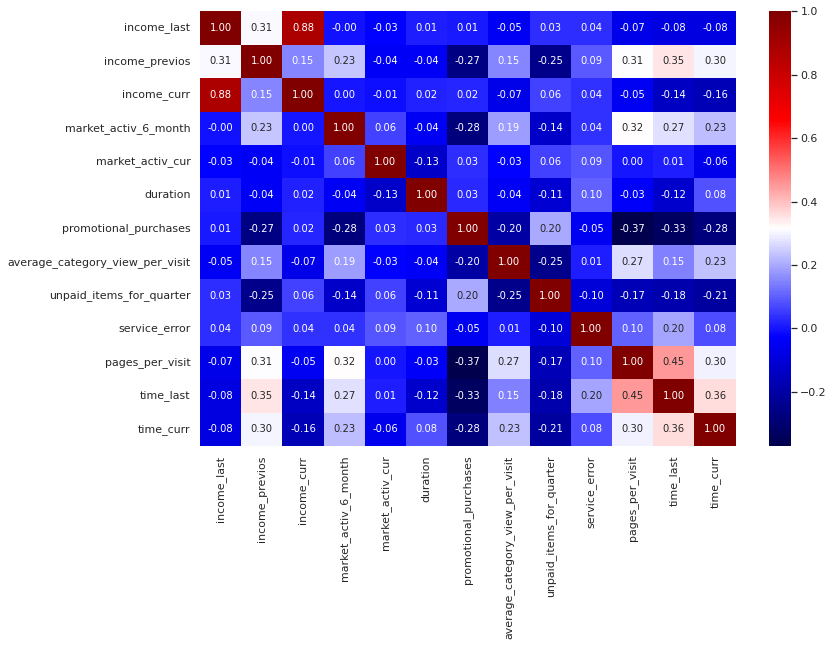

In [69]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns='id').corr(method='spearman',
                                       numeric_only=True), 
            annot=True, 
            cmap='seismic', 
            fmt=".2f");

In [70]:
df_numerical = {    
    'market_activ_6_month': 'Маркет_актив_6_мес',
    'promotional_purchases': 'Акционные_покупки',
    'average_category_view_per_visit': 'Средний_просмотр_категорий_за_визит',
    'unpaid_items_for_quarter': 'Неоплаченные_продукты_штук_квартал',
    'service_error': 'Ошибка_сервиса',
    'pages_per_visit': 'Страниц_за_визит',
    'time_last': 'предыдущий_месяц_время',
    'income_last': 'предыдущий_месяц_выручка',
    'income_previos': 'препредыдущий_месяц_выручка',
    'income_curr': 'текущий_месяц_выручка'
}

In [71]:
df_numerical.keys()

dict_keys(['market_activ_6_month', 'promotional_purchases', 'average_category_view_per_visit', 'unpaid_items_for_quarter', 'service_error', 'pages_per_visit', 'time_last', 'income_last', 'income_previos', 'income_curr'])

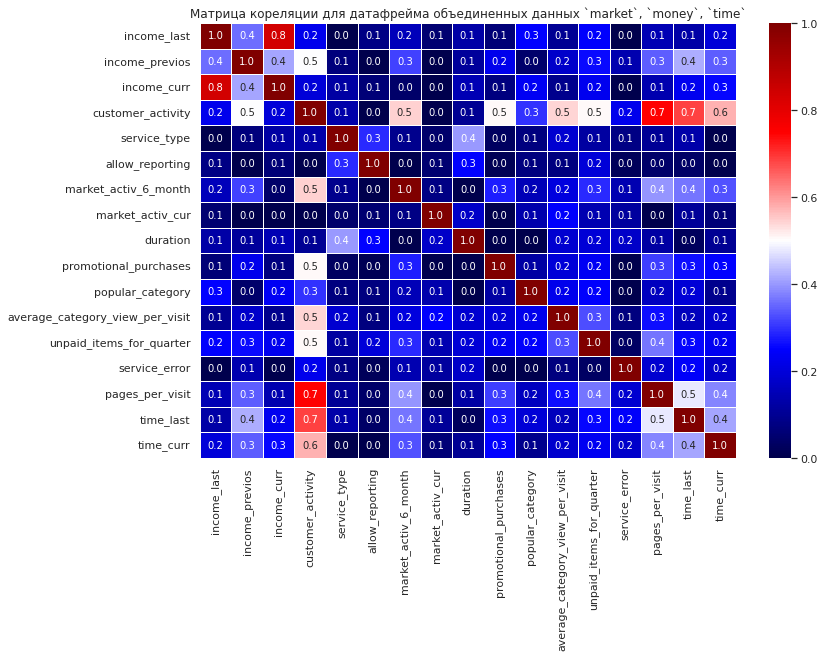

In [72]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df.drop(columns='id').phik_matrix(interval_cols=df.select_dtypes(include='number').columns), 
                 cmap='seismic', 
                 annot=True, 
                 fmt=".1f", 
                 linewidth=.5)
ax.set_title('Матрица кореляции для датафрейма объединенных данных `market`, `money`, `time`');

Видно сильную корреляцию между признаками `pages_per_visit` и `time_last` с целевым признаком `customer_activity` равную 0.7

Также видно сильную корреляцию между признаками `income_last` c `income_curr`. То есть если покупатель приобретал в прошлом месяце много, то и в следующем он покупает много.

In [73]:
def plot_correlation(df: pd.DataFrame, field: str = 'customer_activity', 
                     signs: dict = df_numerical) -> None:
    # Создание комбинаций признаков
    feature_combinations = combinations(signs.keys(), 2)
    num_plots = len(list(feature_combinations))
    
    # Построение диаграмм рассеяния для каждой комбинации
    num_cols = min(num_plots, 5)  # Определяем количество колонок в сетке
    num_rows = (num_plots - 1) // 5 + 1  # Определяем количество строк в сетке
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))
    
    # Итерация по комбинациям признаков
    row_idx = 0
    col_idx = 0
    for feat1, feat2 in combinations(signs.keys(), 2):
        ax = axes[row_idx, col_idx]
        sns.scatterplot(data=df, x=feat1, y=feat2, hue=field, ax=ax)
        ax.set_xlabel(signs[feat1])
        ax.set_ylabel(signs[feat2])
        ax.set_title(f'{signs[feat1]} vs {signs[feat2]}')
        
        # Обновляем индексы строк и столбцов
        col_idx += 1
        if col_idx == num_cols:
            row_idx += 1
            col_idx = 0
    
    plt.tight_layout()

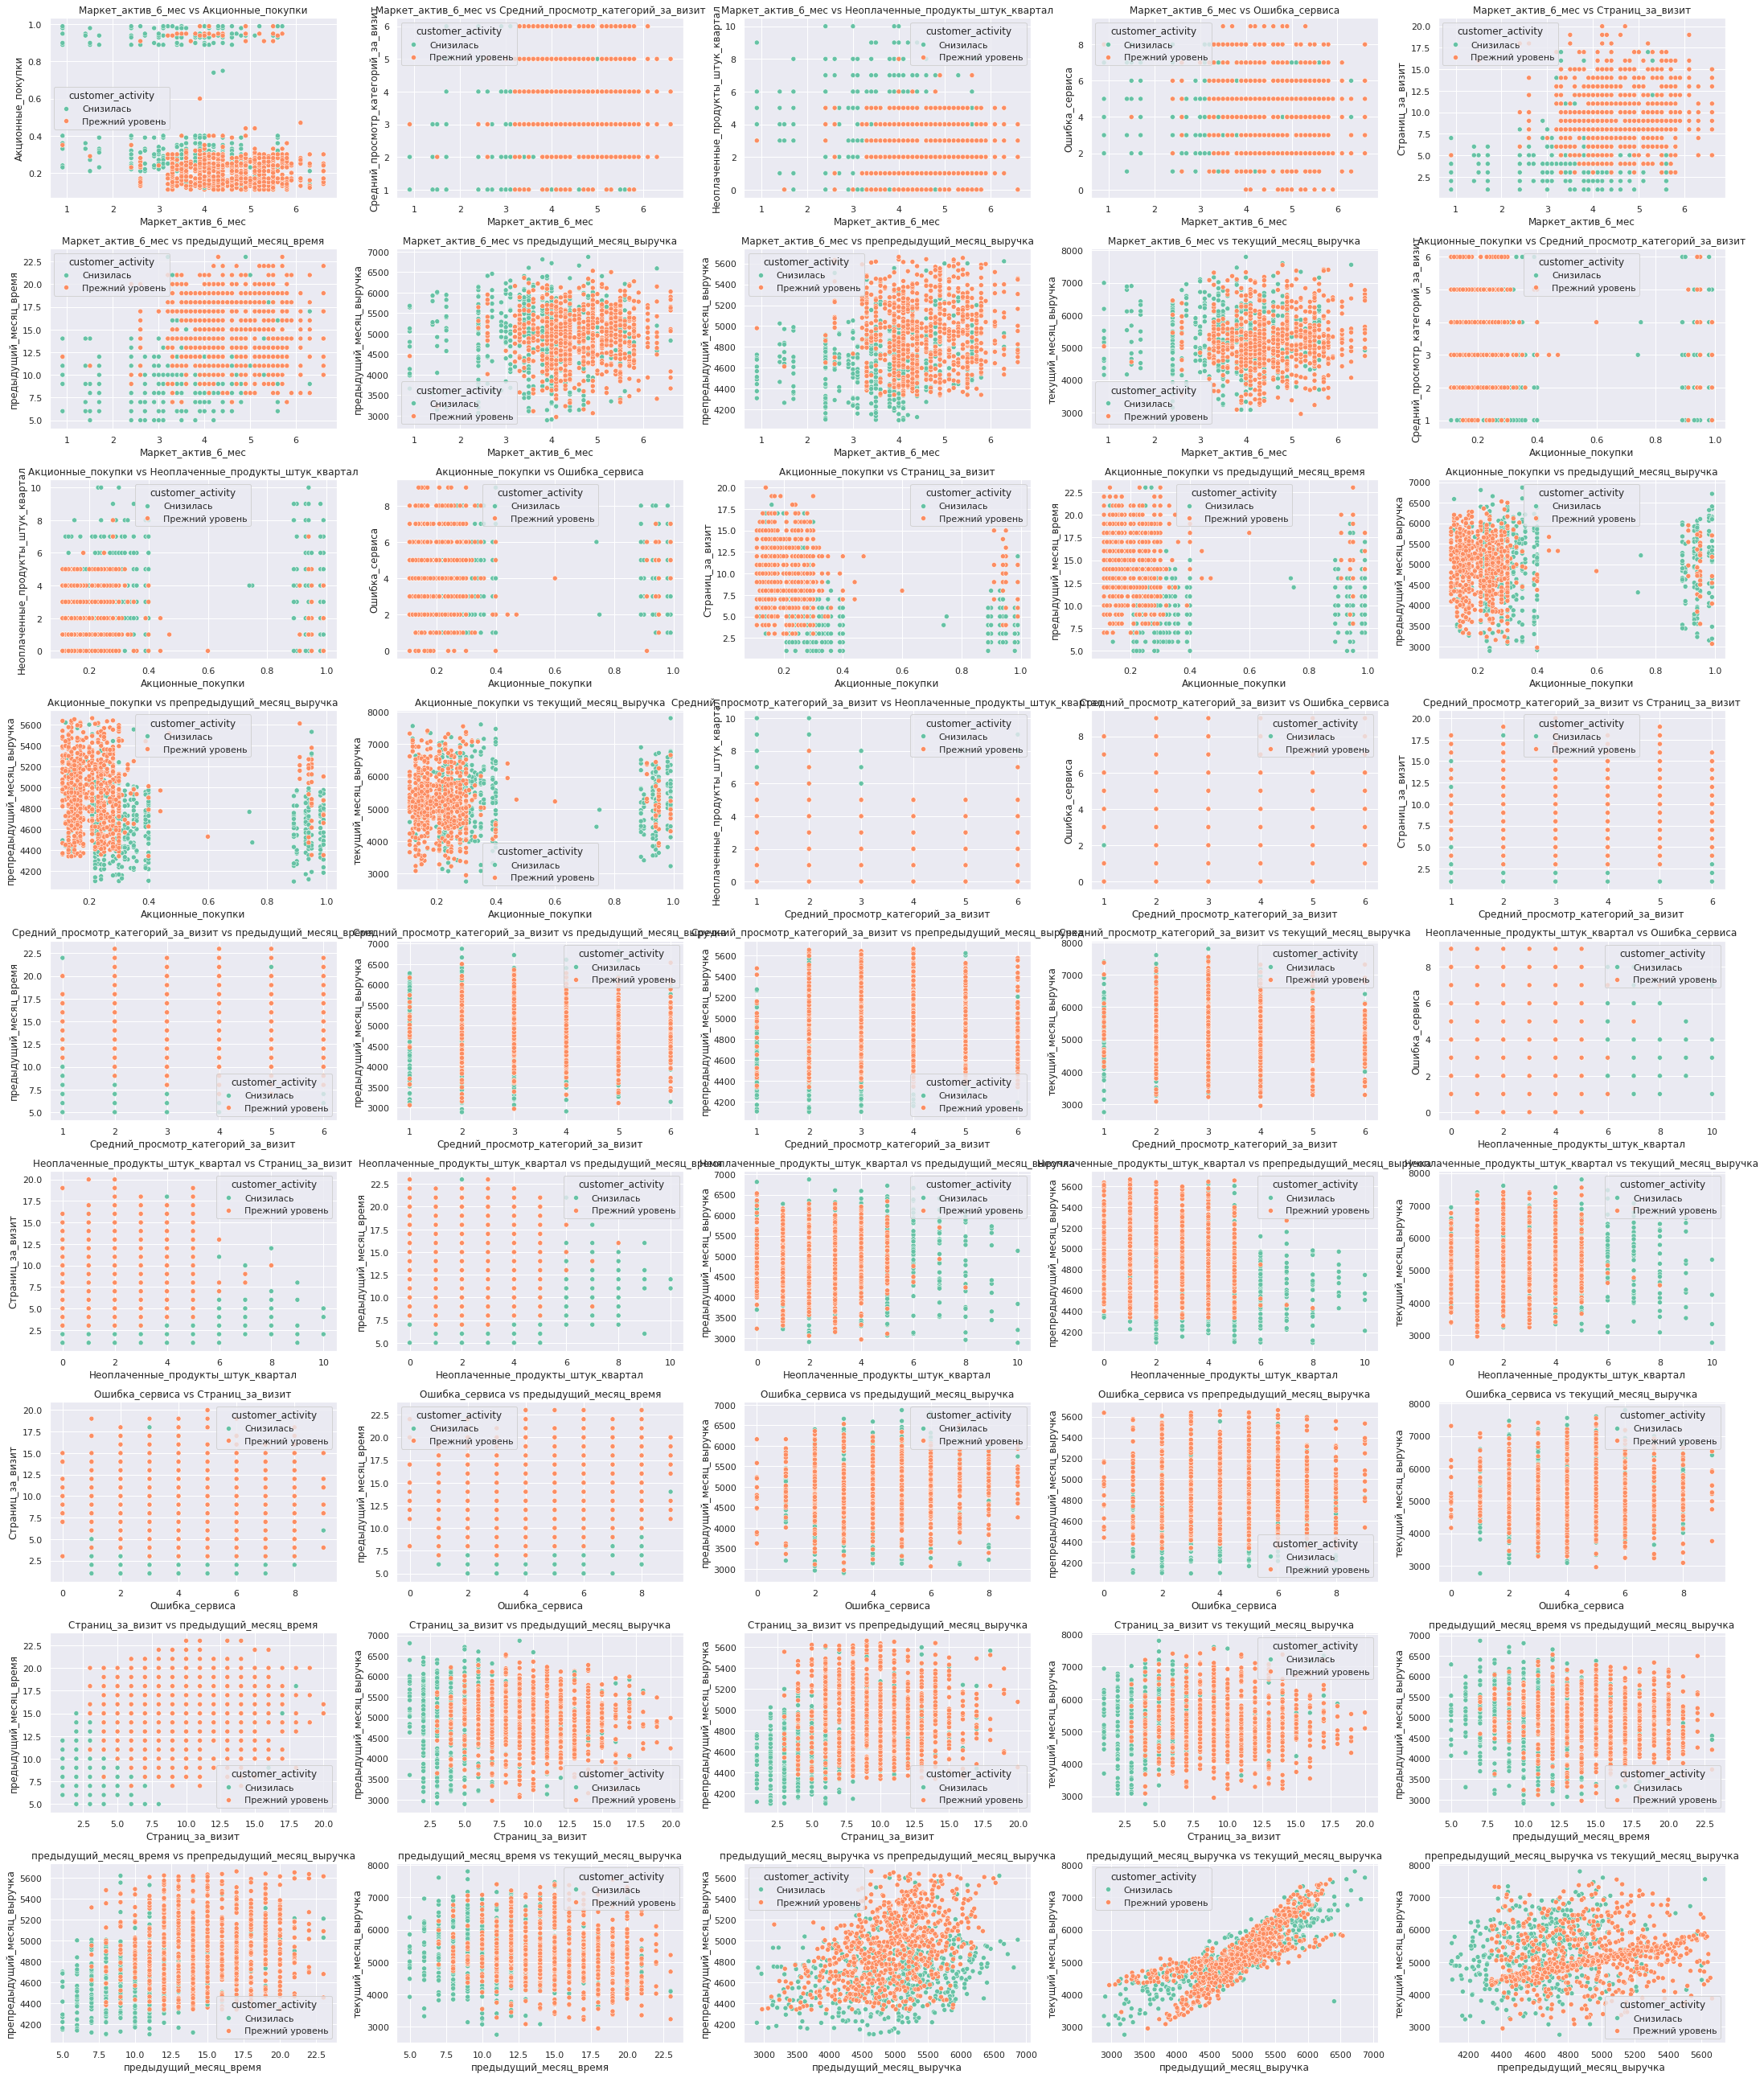

In [74]:
plot_correlation(df)

Очень интересная зависимость между данными о выручке за предыдущий и текущий месяц. Велика вероятность, что они слишком зависят друг от друга - если пользователь тратил определенное количество денег в прошлом месяце, то он потратит и в этом.

Вывод: мультиколлинеарности в данных не наблюдается, поэтому не было произведено удаление данных.

## **Использование пайплайнов**

Применение моделей через пайплайны:
   - Создать пайплайн для подготовки данных с использованием ColumnTransformer, где количественные и категориальные данные будут обрабатываться раздельно.
   - Разработать пайплайн для выбора наилучшей модели среди изученных: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC().
   - Для каждой модели провести подбор как минимум одного гиперпараметра. Применить как минимум два метода масштабирования данных.
   - Определить и выбрать подходящую метрику для оценки моделей, обосновав свой выбор.

In [75]:
X = df.drop(columns=['customer_activity', 'id'])
y = df['customer_activity']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   stratify=y,
                                                   random_state=RANDOM_STATE)

In [76]:
ohe_columns = ['allow_reporting', 'popular_category']
ord_columns = ['service_type']
num_columns = ['market_activ_6_month', 'promotional_purchases', 'average_category_view_per_visit', 'unpaid_items_for_quarter', 
               'service_error', 'pages_per_visit', 'time_last', 'income_last', 'income_previos', 'income_curr']

ohe_pipe = Pipeline([
    ('SimpleInputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

ord_pipe = Pipeline([
    ('SimpleInputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=[
        ['стандарт', 'премиум']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('SimpleInputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('SimpleInputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

df_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
],
remainder='passthrough')

final_pipe = Pipeline([
    ('preprocessor', df_preprocessor),
    ('models', LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE))
])

In [77]:
params_grid = [
    {
        'models': [LogisticRegression(penalty='l1', random_state=RANDOM_STATE)],
        'models__solver': ['saga', 'liblinear'],
        'models__C': range(1, 4),
        'models__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        'models__class_weight': ['balanced']
    },
]

label_encoder = LabelEncoder()

In [78]:
y_train_encoder = label_encoder.fit_transform(y_train)
y_test_encoder = label_encoder.transform(y_test)

Проверка кодировки

In [79]:
y_train[:5]

225          Снизилась
396    Прежний уровень
941    Прежний уровень
131          Снизилась
95           Снизилась
Name: customer_activity, dtype: object

In [80]:
y_train_encoder[:5]

array([1, 0, 0, 1, 1])

In [81]:
randomized_search = RandomizedSearchCV(
    final_pipe, 
    params_grid, 
    cv=5,
    scoring='recall',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10,
    error_score='raise'
)
randomized_search.fit(X_train, y_train_encoder)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleInputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('hot_encoder',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['allow_reporting',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeClassifier(random_state=5)],
                                         'models__class_weight': ['balanced'],
                                         'models__max_depth': range(2, 5),
                                         'models__min_samples_leaf': range(2, 5),
                                         'models__min_samples_split': range(2, 5),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']}],
                   random_state=5, scoring='recall')

In [82]:
randomized_search.best_params_

{'preprocessor__num': RobustScaler(),
 'models__solver': 'liblinear',
 'models__class_weight': 'balanced',
 'models__C': 3,
 'models': LogisticRegression(C=3, class_weight='balanced', penalty='l1', random_state=5,
                    solver='liblinear')}

In [83]:
randomized_search.best_score_

0.8081081081081081

In [84]:
pred_proba = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика roc_auc на тестовой выборке: {round(roc_auc_score(y_test, pred_proba), 2)}')

Метрика roc_auc на тестовой выборке: 0.91


In [85]:
y_test.value_counts()

customer_activity
Прежний уровень    200
Снизилась          124
Name: count, dtype: int64

In [86]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='mean_test_score', ascending=True).head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.130658      0.005203         0.012826        0.000200   
2       0.015267      0.000340         0.010884        0.000428   
3       0.015163      0.000183         0.010878        0.000828   
1       0.043404      0.051127         0.027039        0.032568   
5       0.018244      0.000905         0.008687        0.001058   
6       0.018196      0.000246         0.008427        0.000274   
9       0.015015      0.000153         0.006949        0.000126   
4      86.836750     10.612363         0.010556        0.000159   
0       0.070259      0.084499         0.009208        0.000226   
8       0.024631      0.002120         0.009136        0.000311   

  param_preprocessor__num param_models__solver param_models__class_weight  \
7          MinMaxScaler()                  NaN                   balanced   
2          MinMaxScaler()                  NaN                        NaN   
3        StandardScaler()                  NaN                        NaN   
1        StandardScaler()                  NaN                        NaN   
5          MinMaxScaler()                  NaN                   balanced   
6        StandardScaler()                  NaN                   balanced   
9             passthrough                  NaN                   balanced   
4        StandardScaler()                  NaN                   balanced   
0          RobustScaler()            liblinear                   balanced   
8        StandardScaler()            liblinear                   balanced   

  param_models__C                                       param_models  \
7             NaN              SVC(probability=True, random_state=5)   
2             NaN                             KNeighborsClassifier()   
3             NaN                             KNeighborsClassifier()   
1             NaN                             KNeighborsClassifier()   
5             NaN             DecisionTreeClassifier(random_state=5)   
6             NaN             DecisionTreeClassifier(random_state=5)   
9             NaN             DecisionTreeClassifier(random_state=5)   
4             NaN              SVC(probability=True, random_state=5)   
0               3  LogisticRegression(C=3, class_weight='balanced...   
8               1  LogisticRegression(C=3, class_weight='balanced...   

  param_models__weights  ... param_models__max_depth  \
7                   NaN  ...                     NaN   
2              distance  ...                     NaN   
3              distance  ...                     NaN   
1              distance  ...                     NaN   
5                   NaN  ...                       4   
6                   NaN  ...                       4   
9                   NaN  ...                       3   
4                   NaN  ...                     NaN   
0                   NaN  ...                     NaN   
8                   NaN  ...                     NaN   

                                              params split0_test_score  \
7  {'preprocessor__num': MinMaxScaler(), 'models_...          0.216216   
2  {'preprocessor__num': MinMaxScaler(), 'models_...          0.472973   
3  {'preprocessor__num': StandardScaler(), 'model...          0.486486   
1  {'preprocessor__num': StandardScaler(), 'model...          0.567568   
5  {'preprocessor__num': MinMaxScaler(), 'models_...          0.797297   
6  {'preprocessor__num': StandardScaler(), 'model...          0.797297   
9  {'preprocessor__num': 'passthrough', 'models__...          0.797297   
4  {'preprocessor__num': StandardScaler(), 'model...          0.824324   
0  {'preprocessor__num': RobustScaler(), 'models_...          0.824324   
8  {'preprocessor__num': StandardScaler(), 'model...          0.824324   

  split1_test_score split2_test_score split3_test_score  split4_test_score  \
7          0.175676          0.175676          0.202703           0.081081   
2          0.432432          0.43243

In [87]:
best_decision = randomized_search.best_estimator_
best_model = best_decision.named_steps['models']

In [88]:
y_pred = randomized_search.predict(X_test)

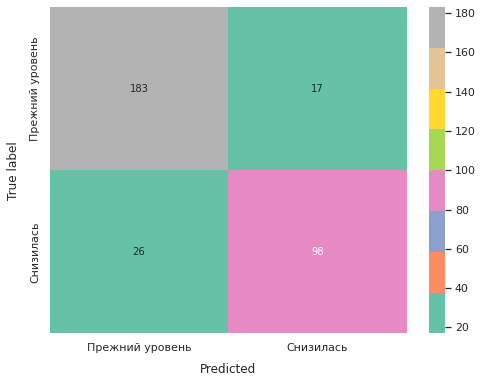

In [108]:
cm = confusion_matrix(y_test_encoder, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Set2', 
            xticklabels=['Прежний уровень', 'Снизилась'], 
            yticklabels=['Прежний уровень', 'Снизилась'])
plt.ylabel('True label', labelpad=10)
plt.xlabel('Predicted', labelpad=10);


**Вывод**: 

Подобранная в результате перебора гиперпараметров модель работает корректно и почти удовлетворяет нашим потребностям - нам необходимо не пропустить клиентов со снижением активности и лучше присвоить клиентам с прежним уровнем активности снижение, чем пропустить клиента со снижением. В результате перебора была подобрана модель логистической регрессии с гиперпараметрами C=3, class_weight='balanced', penalty='l1', random_state=5,  solver='liblinear)

## **Анализ важности признаков**

- Оценить значимость признаков для лучшей модели и визуализировать её с помощью метода SHAP.
- Сделать выводы о значимости признаков, выделив:
     - Признаки с наименьшей значимостью для модели.
     - Признаки с наибольшим влиянием на целевой признак.
     - Разработать рекомендации по использованию этих наблюдений при моделировании и принятии бизнес-решений.

In [90]:
best_decision.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('SimpleInputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('hot_encoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore'))]),
                                  ['allow_reporting', 'popular_category']),
                                 ('ord',
                                  Pipeline(steps=[('SimpleInputer_before',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('ord_encoder',...
                                                                  handle_unknown='use_encoded_value',
                                           

In [91]:
best_decision.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleInputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['allow_reporting',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleInputer_before',
                                                                   SimpleImputer(strategy='...
                                                  ['service_type']),
                                                 ('num', RobustScaler(),
                                                  ['market_activ_6_month',
                                                   'promotional_purchases',
                                                   'average_category_view_per_visit',
                                                   'unpaid_items_for_quarter',
                                                   'service_error',
                                                   'pages_per_visit',
                                                   'time_last', 'income_last',
                                                   'income_previos',
                                                   'income_curr'])])),
                ('models',
                 LogisticRegression(C=3, class_weight='balanced', penalty='l1',
                                    random_state=5, solver='liblinear'))])

In [92]:
x_Train = pd.DataFrame(best_decision['preprocessor'].fit_transform(X_train),
                      columns=best_decision.named_steps['preprocessor'].get_feature_names_out())
x_Test = pd.DataFrame(best_decision['preprocessor'].transform(X_test),
                     columns=best_decision.named_steps['preprocessor'].get_feature_names_out())

In [93]:
explainer = shap.KernelExplainer(best_model.predict_proba, x_Train[:10])

shap_values = explainer.shap_values(x_Test[:10])[:, :, 0]
shap.force_plot(explainer.expected_value[0], shap_values, x_Test)


  0%|          | 0/10 [00:00<?, ?it/s]

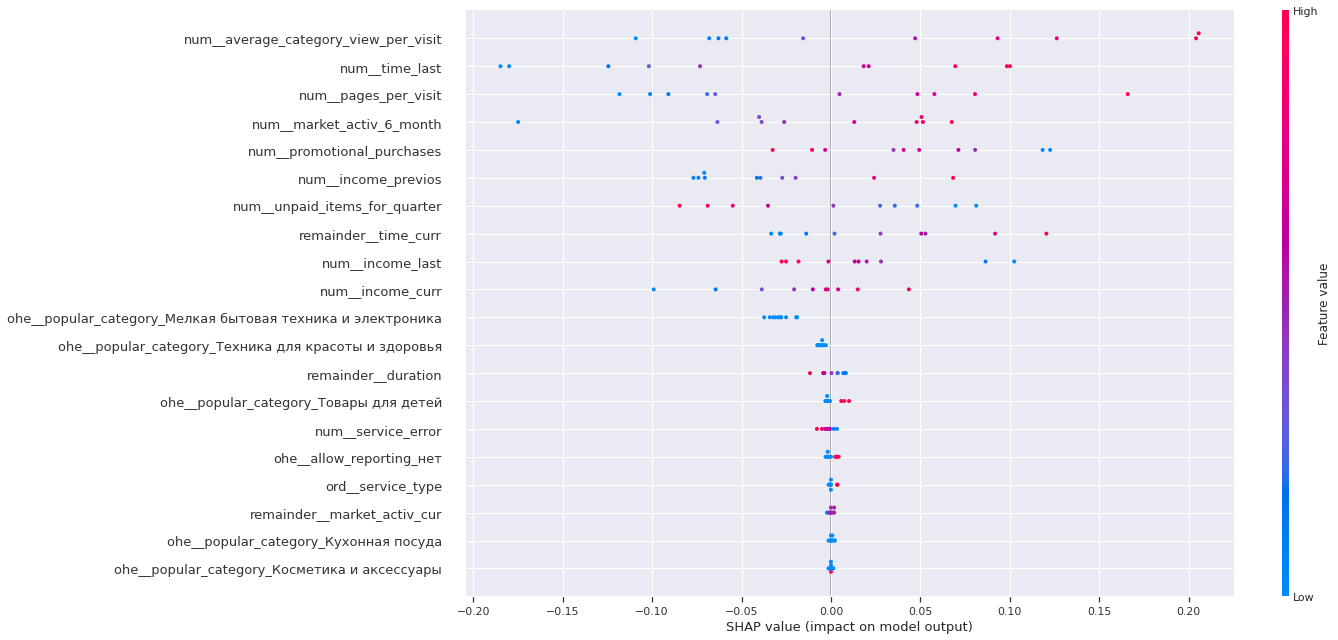

In [94]:
shap.summary_plot(shap_values, x_Test[:10], plot_size=(20,9))

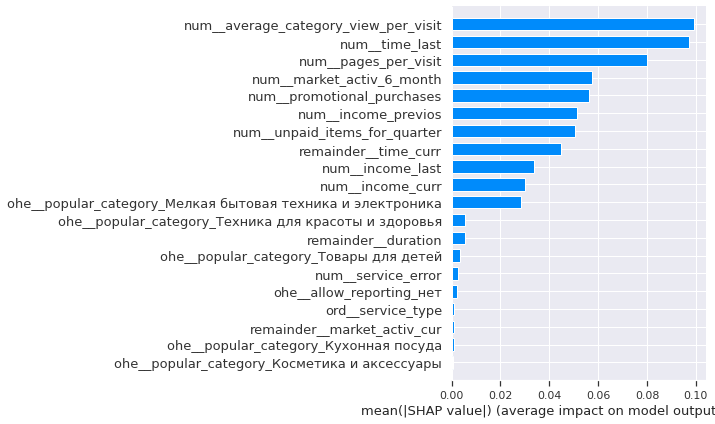

In [95]:
shap.summary_plot(shap_values, x_Test[:10], plot_type="bar", plot_size=(10,6))

In [96]:
feature = pd.DataFrame(best_model.coef_,
                      columns=best_decision.named_steps['preprocessor'].get_feature_names_out(),
                      index=['importance']).transpose().sort_values(by='importance', ascending=False)
feature

importance
num__unpaid_items_for_quarter                         0.743052
num__promotional_purchases                            0.352800
num__income_last                                      0.339097
num__service_error                                    0.043846
remainder__duration                                   0.000220
ohe__popular_category_Кухонная посуда                 0.000000
ohe__popular_category_Косметика и аксессуары          0.000000
remainder__market_activ_cur                          -0.006578
ohe__allow_reporting_нет                             -0.026237
ord__service_type                                    -0.027361
ohe__popular_category_Товары для детей               -0.065372
remainder__time_curr                                 -0.104139
num__income_curr                                     -0.345811
num__income_previos                                  -0.392651
ohe__popular_category_Техника для красоты и здо...   -0.442583
num__market_activ_6_month                            -0.465227
num__average_category_view_per_visit                 -0.871656
num__pages_per_visit                                 -0.882850
num__time_last                                       -0.911612
ohe__popular_category_Мелкая бытовая техника и ...   -1.014265

**Вывод**:
Можно сделать вывод, что количество неоплаченных товаров и акций влияет на активность, так же на основании потраченных денег за последний месяц можно сделать предположение, именно эти категории больше всего информации смогут дать о том, снизится ли активность пользователя

## **Сегментация покупателей**

Мы хотим удержать активность пользователей, однако большое количество промо покупок и неоплаченных товаров может повлиять на их текущую активность. Проанализируем данный сегмент - пользователи, активно пользующиеся акциями и хранящие в корзине неоплаченные товары. При построении графиков будем отталкиваться также от их прибыльности для компании и дохода за последний месяц, который так же влияет на активность пользователя.

Для начала рассмотрим количество неоплаченных товаров в зависимости от самой популярной категории - это поможет оценить, какие категории пользуются меньшей покупательской способностью

In [97]:
def categorial_plot(df: pd.DataFrame, title: str, features: dict) -> None:
    '''
    Function for plotting categorial distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data = df[feature].value_counts().to_frame().reset_index()
        if len(data['count'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(20, 4))
            fig.suptitle(f'Распределение для {feat_ru}')
            axes[0].yaxis.grid(True)
            sns.barplot(data=data, y=feature, x='count', ax=axes[0])
            axes[0].set_xlabel('Количество', fontsize=12)
            axes[0].set_ylabel(feat_ru, fontsize=12)
            axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
        else:
            print(f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

In [98]:
def category_plot(df: pd.DataFrame, search: list = ['popular_category', 'customer_activity']) -> None:
    '''
    Plot the distribution of users in case of activity and number of unpaid items
    '''
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    
    for num, data in enumerate(search):
        sns.histplot(data=df, x='unpaid_items_for_quarter', hue=data, multiple="dodge", ax=axes[num])
        axes[num].set_xlabel('Количество неоплаченных товаров за квартал')
        axes[num].set_ylabel('Количество пользователей')
    
    axes[0].set_title('Распределение пользователей по категориям неоплаченных товаров')
    axes[1].set_ylabel('Количество пользователей');

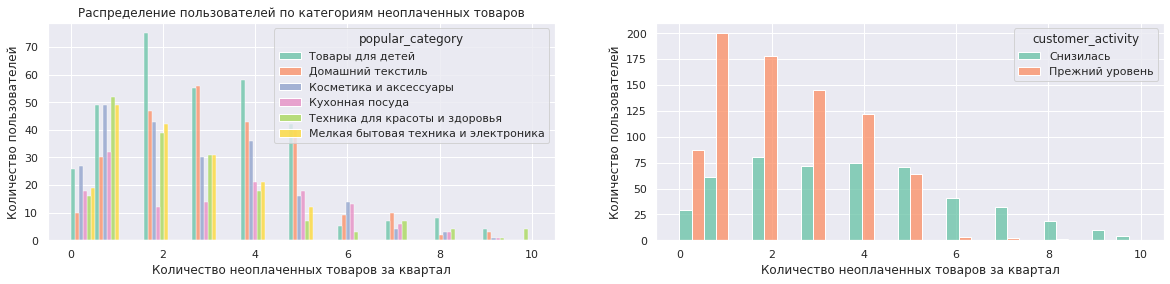

In [99]:
category_plot(df)

На основании этого можно увидеть, что начиная с 5 товаров в корзине снижается активность пользователей. Для данного количества неоплаченных товаров наиболее популярными категориями являются товары для детей и предметы для дома: домашний текстиль и кухонная посуда. Построим аналогичный график с выделением этих категорий, чтобы оценить их влияние на активность пользователя совместно с количеством неоплаченных товаров

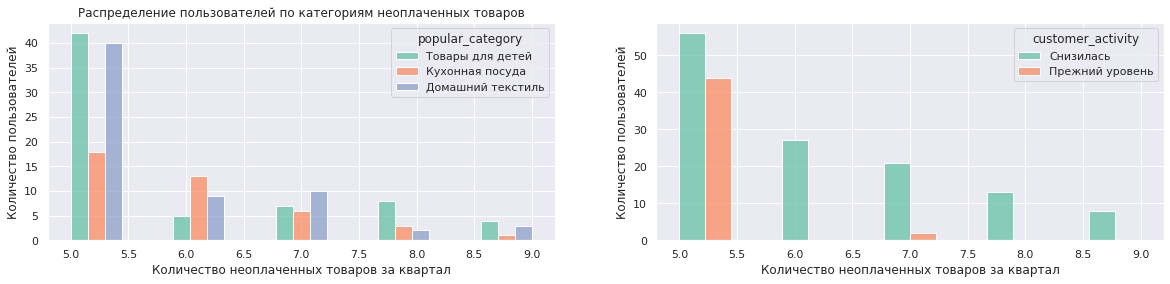

In [107]:
category_plot(df.query('unpaid_items_for_quarter > 4 and popular_category.isin(["Товары для детей", \
                       "Домашний текстиль", "Кухонная посуда"])'))

На основании полученных данных можно преположить, что при количестве неоплаченных товаров 4 и при больше 5 и категориях товары для детей, кухонная посуда, домашний текстиль, покупательская активность снизится.

Рассмотрим теперь влияние акционных покупок на покупательскую активность и рассмотрим так же, какую выручку получает сервис. Так же посмотрим на то, какую часть составляют акционные покупки в зависимости от неоплаченных товаров.

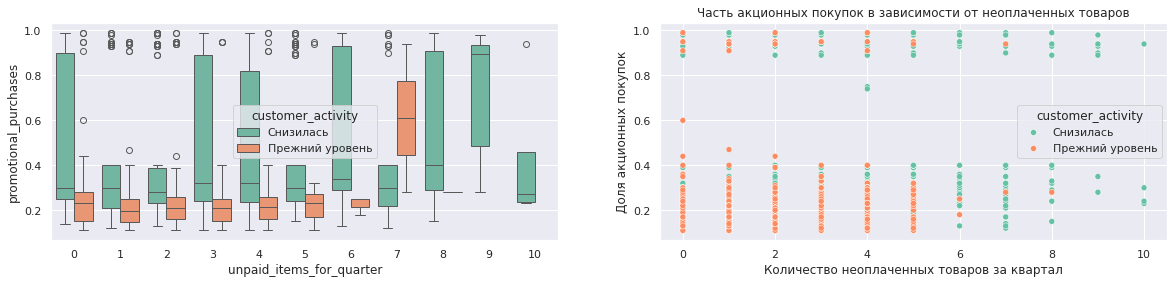

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='unpaid_items_for_quarter', y='promotional_purchases', data=df, hue='customer_activity', ax=axes[0])
sns.scatterplot(x='unpaid_items_for_quarter', y='promotional_purchases', data=df, hue='customer_activity', ax=axes[1])
plt.title('Часть акционных покупок в зависимости от неоплаченных товаров')
plt.xlabel('Количество неоплаченных товаров за квартал')
plt.ylabel('Доля акционных покупок')
plt.show()

На основании полученного графика можно оценить, что при доли акционных покупок более 30% от общей суммы, снижается пользовательская активность

Объединим датафрейм с прибылью от пользователя и оценим насколько зависят выручка и прибыль от активности пользователя

In [102]:
df_full = df.merge(income_money, on='id')

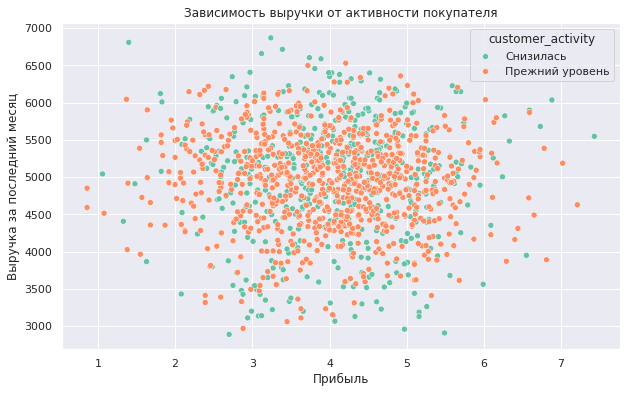

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='profit', y='income_last', data=df_full, hue='customer_activity')
plt.title('Зависимость выручки от активности покупателя')
plt.xlabel('Прибыль')
plt.ylabel('Выручка за последний месяц');

На данном графике все неоднозначно. Выделим сегментированную выше категорию людей, чтобы оценить их затраты

In [104]:
segment = df_full.query('unpaid_items_for_quarter > 4 | promotional_purchases > 0.3')

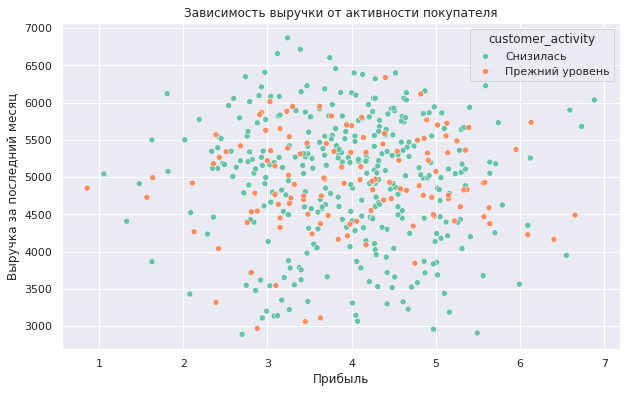

In [105]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='profit', y='income_last', data=segment, hue='customer_activity')
plt.title('Зависимость выручки от активности покупателя')
plt.xlabel('Прибыль')
plt.ylabel('Выручка за последний месяц');

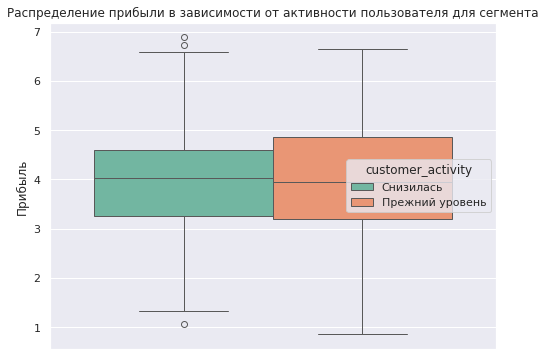

In [106]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=segment, y='profit', hue='customer_activity')
plt.title('Распределение прибыли в зависимости от активности пользователя для сегмента')
plt.ylabel('Прибыль');

При выделении группы людей с неоплаченными товарами и акционными покупками выше 30 процентов мы натыкаемся на превалирующее число пользователей со снижением уровня активности. Однако эти пользователи в среднем приносили хорошую выручку. Для повышения их активности и поддержания данной категории пользователей стоит хорошо продумывать акционные мероприятия, возможно давать промокоды при покупке от некоторого количества вещей, либо подобрать категорию товаров для акций, например `Товары для детей`, `Домашний текстиль`, `Кухонная посуда`

## **Общий вывод**

Стояла задача проанализировать категории пользователей, которые можно выделить в отдельный сегмент для создания персонализированного предложения.

<u>На этапе анализа данных</u> были проанализированны полученные данные и  было проведено переименование столбцов для удобства работы с датафреймами. Во всех датафреймах не обнаружено пропусков, и явных дубликатов.

<u>На этапе предобработки:</u>

В датафрейме `market` был удален неявный дубликат в столбце `service_type`, а в датафреймах `time` и `market` были исправлены опечатки в данных. 

Во время исследовательского анализа данных были обнаружены следующие особенности:

- В датафрейме `market`:
    - Для категориальных признаков:
        - Пользователи в основном используют стандартный тип сервиса
        - 74% пользователей разрешили получать уведомления о акциях и прочем при помощи рассылки
        - Самая популярная категория среди пользователей - товары для детей
    - Для количественных признаков:
        - Нет стандартного распределения для `market_activ_6_month`, наблюдаются пики для значений 4 и 5.5
        - Большая доля активности в месяц приходится на значение 4 для `market_activ_cur`
        - Для duration и других признаков также нельзя сказать о стандартном расределении

- В датафрейме `money`:
    - Был удален выброс с выручкой более 100000
    - Нормально распределен признак `income`, отвечающий за сумму выручки
    - Данные за период разделены н три категории

- В датафрейме `time`:
    - Нормально несимметрично со смещением влево распределен признак `time`
    - Для категориального признака `period` одинаковое количество днных на все группы

- В датафрейме `income_money`:
    - Нормально несимметрично со смещением вправо распеделен признак `profit`

Было произведено объединение данных датафреймов `market`, `money`, `time` в отдельных датафрейм с разделением данных о времени и выручке за каждый период в разные столбцы

Был проведен корреляционный анализ, в результате которого были отмечены
- сильная корреляция между признаками `pages_per_visit` и `time_last` с целевым признаком `customer_activity` равную 0.7
- сильная корреляция между признаками `income_last` c `income_curr`. То есть если покупатель приобретал в прошлом месяце много, то и в следующем он покупает много.
Данных удалено не было, поскольку чистой мультиколлинеарности не было найдено

Для поиска лучшей модели был создан конвейер обработки данных, который включал в себя кодирование категориальных признаков с помощью OneHotEncoder и OrdinalEncoder, а также нормализацию числовых признаков с помощью StandardScaler. Далее был создан итоговый конвейер, который объединял предобработку данных и модель LogisticRegression с параметрами penalty='l1' и solver='liblinear'.

Для подбора лучшей модели был использован RandomizedSearchCV, который проводил поиск по заданным параметрам для нескольких моделей: LogisticRegression, SVC, KNeighborsClassifier, DecisionTreeClassifier. Поиск осуществлялся с использованием метрики Recall (полнота) и проводился с помощью кросс-валидации на 5 фолдах.

Лучшая модель была выбрана на основе результатов RandomizedSearchCV, которая оказалась LogisticRegression с параметрами penalty='l1', solver='liblinear' и C=1. 

<u>В результате анализа важности признаков</u> был сделан вывод, что количество неоплаченных товаров и акций влияет на активность, так же на основании потраченных денег за последний месяц можно сделать предположение, именно эти категории больше всего информации смогут дать о том, снизится ли активность пользователя

Была проведена сегментация пользователей с неоплаченными товарами больше 4 или акционными покупками более 30%

В результате анализа было обнаружено, что большинство пользователей в этой группе проявляют снижение уровня активности. Однако, в среднем, эти пользователи приносят хорошую выручку. Для поддержания и повышения активности данной категории пользователей рекомендуется тщательно разрабатывать акционные мероприятия. Например, предоставлять промокоды при покупке определенного количества товаров или проводить акции в определенных категориях товаров, таких как Товары для детей, Домашний текстиль, Кухонная посуда. Эти шаги могут способствовать увеличению уровня активности и удержанию данной группы пользователей.